# Denoising Neural Network

In [11]:
import sys 
sys.path.append("../")

import torch 
import torch.nn

from Conv1d_NN import Conv1d_NN

from models import * 
from train import * 
from dataset import * 


### Getting Denoising Data 

In [12]:
# Noisy Data
noisy_dataset = MNIST1D_Dataset()
print(noisy_dataset.data_args.iid_noise_scale, noisy_dataset.data_args.corr_noise_scale)
noisy_data = noisy_dataset.make_dataset()


# Clean Data 
clean_dataset = MNIST1D_Dataset()
clean_dataset.data_args.iid_noise_scale = 0.0
clean_dataset.data_args.corr_noise_scale = 0.0
print(clean_dataset.data_args.iid_noise_scale, clean_dataset.data_args.corr_noise_scale)

clean_data = clean_dataset.make_dataset()


0.02 0.25
0.0 0.0


### Visualize data 

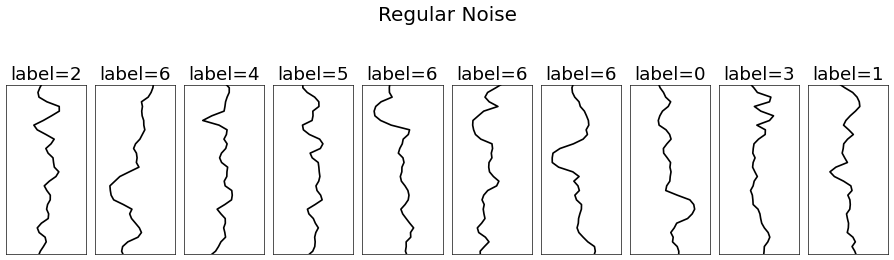

In [13]:
Plot = MNIST1D_Plot()

Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Regular Noise')


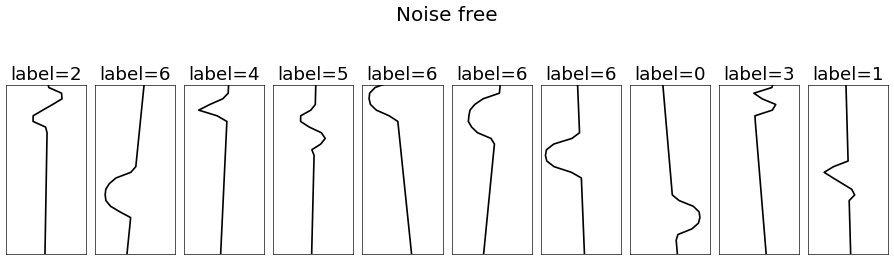

In [14]:
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Noise free')


### Get Models for testing

In [15]:
# Denoiser CNN model
model1 = ConvDenoiser()

# Get summary 
from torchsummary import summary
summary(model1, input_size=(1, 40), device="cpu")  

Initialized ConvDenoiser model with 5505 parameters
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 40]             192
            Conv1d-2               [-1, 32, 40]           5,152
            Conv1d-3                [-1, 1, 40]             161
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [16]:
# Denoiser Conv1d_NN Model
model2 = nn.Sequential(
   BranchingNetwork(in_ch = 1, out_ch1 = 16, out_ch2=16, kernel_size = 3), 
   BranchingNetwork(in_ch = 16, out_ch1 = 8, out_ch2=8, kernel_size = 3),
   BranchingNetwork(in_ch = 8, out_ch1 = 4, out_ch2=4, kernel_size =3), 
   BranchingNetwork(in_ch = 4, out_ch1 = 2, out_ch2=2, kernel_size =3), 
   BranchingNetwork(in_ch = 2, out_ch1 = 1, out_ch2=1, kernel_size =3) 
)

# Get summary
from torchsummary import summary 
summary(model2, (1, 40), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 38]              64
              ReLU-2               [-1, 16, 38]               0
            Conv1d-3               [-1, 16, 40]              64
         Conv1d_NN-4               [-1, 16, 40]               0
              ReLU-5               [-1, 16, 40]               0
            Conv1d-6               [-1, 16, 40]             528
  BranchingNetwork-7               [-1, 16, 40]               0
            Conv1d-8                [-1, 8, 38]             392
              ReLU-9                [-1, 8, 38]               0
           Conv1d-10                [-1, 8, 40]             392
        Conv1d_NN-11                [-1, 8, 40]               0
             ReLU-12                [-1, 8, 40]               0
           Conv1d-13                [-1, 8, 40]             136
 BranchingNetwork-14                [-1

### Training & Results

In [17]:
# Regular CNN 
print("Results for Regular CNN")
model1_results = train_model_denoise(noisy_data, clean_data, model1, noisy_dataset.model_args)
print() 

# Branching 
print("Results for Branching CNN")
model2_results = train_model_denoise(noisy_data, clean_data, model2, noisy_dataset.model_args)

print() 

Results for Regular CNN
step 1000, dt 2.72s, train_loss 6.485e-01, test_loss 6.051e-01, train_acc 2.3, test_acc 2.2
step 2000, dt 2.20s, train_loss 6.448e-01, test_loss 6.029e-01, train_acc 2.3, test_acc 2.2
step 3000, dt 2.26s, train_loss 6.435e-01, test_loss 6.025e-01, train_acc 2.4, test_acc 2.2
step 4000, dt 2.24s, train_loss 6.424e-01, test_loss 6.028e-01, train_acc 2.4, test_acc 2.2
step 5000, dt 2.22s, train_loss 6.410e-01, test_loss 6.016e-01, train_acc 2.4, test_acc 2.2
step 6000, dt 2.33s, train_loss 6.400e-01, test_loss 6.030e-01, train_acc 2.4, test_acc 2.2

Results for Branching CNN
step 1000, dt 42.17s, train_loss 1.958e-01, test_loss 1.887e-01, train_acc 7.4, test_acc 7.2
step 2000, dt 40.97s, train_loss 1.788e-01, test_loss 1.760e-01, train_acc 7.7, test_acc 7.5
step 3000, dt 39.16s, train_loss 1.716e-01, test_loss 1.683e-01, train_acc 7.9, test_acc 7.7
step 4000, dt 39.55s, train_loss 1.701e-01, test_loss 1.667e-01, train_acc 8.0, test_acc 7.8
step 5000, dt 40.11s, tra

## Plotting Test sample

Original Input


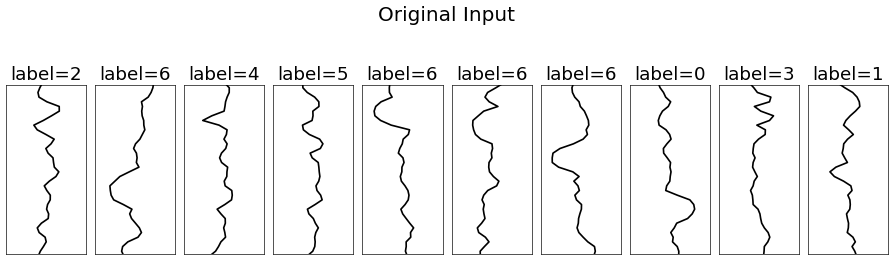

Target Output


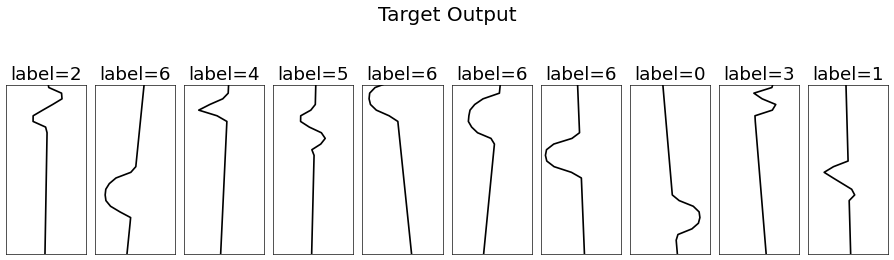

Regular CNN


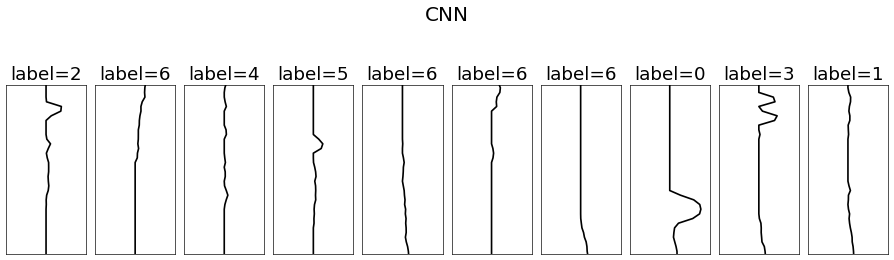

Branching CNN


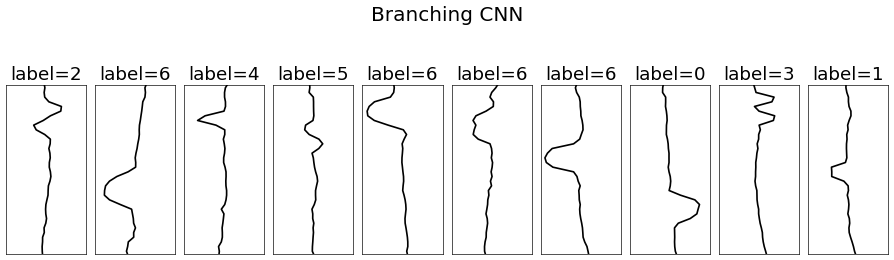

In [19]:
sample = noisy_data['x'][:10].to('mps')

model1 = model1.to('mps')
model2 = model2.to('mps')

reg_output = model1(sample)

branch_output = model2(sample)


reg_output_np = reg_output.detach().cpu().numpy()
branch_output_np = branch_output.detach().cpu().numpy()

# Original Input 
print("Original Input")
Plot.plot_signals(noisy_data['x'][:10], noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Original Input')

# Target 
print("Target Output")
Plot.plot_signals(clean_data['x'][:10], clean_data['t'], labels=clean_data['y'][:10], zoom = 5, title='Target Output')

# Model Prediction
print("Regular CNN")
Plot.plot_signals(reg_output_np, noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='CNN')

print("Branching CNN") 
Plot.plot_signals(branch_output_np, noisy_data['t'], labels=noisy_data['y'][:10], zoom = 5, title='Branching CNN')